In [28]:

# Import packages
import pandas as pd
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from EDA_script_original import *

label_mapping = {-1: 0, 1: 1, 2: 2, 3: 3, 4: 4}
df_y = df_y.replace(label_mapping)

Add all of the preprocessing below

## Variable 1 - 146 Preprocessing

## Variable 147 - 292 Preprocessing 

## Variable 293 - 438 Preprocessing

# Neural Network

In [29]:
# Neural Network
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm

In [30]:
df_z_scaled = df_train.copy()
df_tz = df_test.copy()
# apply normalization techniques 
for column in df_z_scaled.columns:
    df_z_scaled[column] = df_z_scaled[column].astype(float)
    df_z_scaled[column] = (df_z_scaled[column] -
                           df_z_scaled[column].min()) / (df_z_scaled[column].max()- df_z_scaled[column].min())
df_z_scaled_ts = torch.tensor(df_z_scaled.values, dtype=torch.float32)
for column in df_tz.columns:
    df_tz[column] = df_tz[column].astype(float)
    df_tz[column] = (df_tz[column] -
                           df_tz[column].min()) / (df_tz[column].max()- df_tz[column].min())
df_tz = torch.tensor(df_tz.values, dtype=torch.float32)
df_t = torch.tensor(df_y['label'].values, dtype=torch.int64)
df_z_scaled_ts = torch.nan_to_num(df_z_scaled_ts)
df_tz = torch.nan_to_num(df_tz)

In [31]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()
        self.x = df_z_scaled_ts
        self.t = df_t
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.t
    

In [32]:
class datasett(torch.utils.data.Dataset):
    def __init__(self, n=300):
        super().__init__()
        self.x = df_tz
        self.t = df_t
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.t[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.t
    

In [33]:
# Batched, for training
batch_size_train = 256
train_dl = torch.utils.data.DataLoader(dataset(), batch_size=batch_size_train, shuffle=True)
train_all = torch.utils.data.DataLoader(dataset(), batch_size=59438, shuffle=True)
test_all = torch.utils.data.DataLoader(datasett(), batch_size=48000, shuffle=True)

In [34]:
class ClassifierNN(nn.Module):
    '''
     
    '''
    def __init__(self):
        self.losses = []
        super().__init__()
        
        #===== YOUR CODE HERE =====
        self.seq= nn.Sequential(
            nn.Linear(318, 512),
            nn.Sigmoid(),
            nn.Linear(512, 128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 5),
            nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        #===== YOUR CODE HERE =====
        x = self.seq(x)
        return x  # replace this line

In [35]:

df_z_scaled_ts = torch.nan_to_num(df_z_scaled_ts)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [32:26<00:00,  1.95s/it]


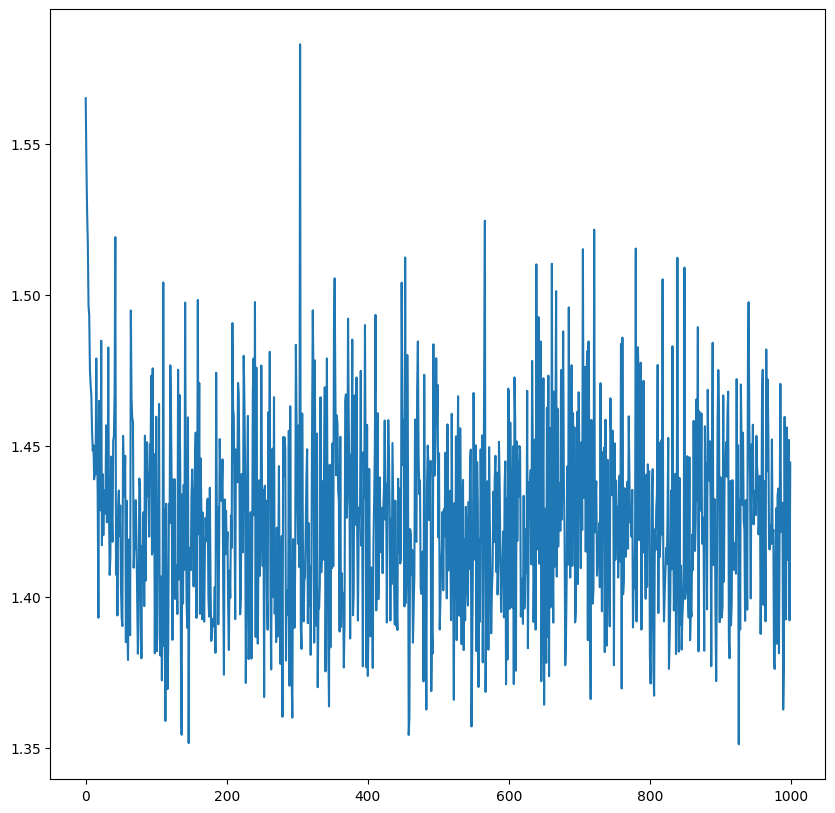

In [36]:
# Train it
net1 = ClassifierNN()
n_epochs = 1000
loss_fn = nn.CrossEntropyLoss(reduction = 'mean')
optimizer = torch.optim.SGD(net1.parameters(), lr=0.0001, momentum=0.8)
for epoch in tqdm(range(n_epochs)):
    for X_batch, y_batch in train_dl:
        y_pred = net1(X_batch)
        torch.nan_to_num(y_pred)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    net1.losses.append(loss.item())
plt.figure(figsize=(10,10))
plt.plot(net1.losses)

y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_all:
        y_pred = np.exp(net1(X_batch))
        
class_order = [0, 1, 2, 3, 4]
class_mapping = {class_label: f"Class_{class_label}" for class_label in class_order}
submission_df = pd.DataFrame(y_pred, columns=class_mapping.values())
submission_df.columns = ['no answer', 'very important', 'quite important', 'not important', 'not at all important']
submission_df.insert(0, 'id', df_test.index)

# Save the submission file
submission_file = 'submission2.csv'
#submission_file = 'submission2.xlsx'
submission_df.to_csv(submission_file, index=False)
##with pd.ExcelWriter(submission_file) as writer:
  ##  submission_df.to_excel(writer, sheet_name="Sheet1") 


In [37]:
from sklearn.metrics import log_loss


with torch.no_grad():
    for X_batch, y_batch in train_all:
        y_pred1 = np.exp(net1(X_batch))
train_last_eval = log_loss(df_y, y_pred1, labels=list(range(5)))
print(f"Training Multiclass Logarithmic Loss: {train_last_eval}")

Training Multiclass Logarithmic Loss: 1.4256116792407614


c:\Python39\lib\site-packages\sklearn\metrics\_classification.py:2981: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
